#### Import libraries / modules

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
os.getcwd()

'C:\\Users\\p.schambach\\Desktop\\DSR\\drone_steering\\models\\playground'

In [5]:
os.chdir('../..')

In [6]:
from app_local.module import DataEnsembler, GestureTransformer

#### Set parameters

In [7]:
is_frame_based = False
ms_per_frame_original = 120
ms_per_frame_interpolated = 50
use_rescaling_to_true_length = True
use_interpolation = True
is_verbose = True
ms_per_frame_interpolated

50

#### Load, interpolate and assemble data

In [8]:
de = DataEnsembler(ms_per_frame=ms_per_frame_original)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = is_frame_based)
de.load_data()

In [9]:
if use_rescaling_to_true_length:
    de.rescale_data_frames(time_of_first_frame = 'avg', verbose=is_verbose)

if use_interpolation:
    if is_frame_based:
        de.interpolate_and_convert_framebased_labels(new_frmlen=ms_per_frame_interpolated, verbose=is_verbose)
    else:
        de.interpolate_data_frames(frmlen=ms_per_frame_interpolated, verbose=is_verbose)

Current Index: 0
Calling DataFrameInterpolator.scaleDataFrame method with current length 66290.0 and actual length 68677
Using 'avg' to calculate new time of first frame: 0.0 ==> 106
Current Index: 1
Calling DataFrameInterpolator.scaleDataFrame method with current length 60562.0 and actual length 63117
Using 'avg' to calculate new time of first frame: 0.0 ==> 112
Current Index: 2
Calling DataFrameInterpolator.scaleDataFrame method with current length 63629.0 and actual length 64048
Using 'avg' to calculate new time of first frame: 0.0 ==> 123
Current Index: 3
Calling DataFrameInterpolator.scaleDataFrame method with current length 69924.0 and actual length 70576
Using 'avg' to calculate new time of first frame: 0.0 ==> 104
Current Index: 4
Calling DataFrameInterpolator.scaleDataFrame method with current length 62303 and actual length 62915
Using 'avg' to calculate new time of first frame: 0 ==> 118
Current Index: 5
Calling DataFrameInterpolator.scaleDataFrame method with current length 

In [10]:
if is_frame_based:
    de.assemble_data(framelength_strategy=ms_per_frame_interpolated)
else:
    de.assemble_data(tolerance_range = 600, max_error = 1000, framelength_strategy=ms_per_frame_interpolated)
    
de.display_information()

i: 0 	shape X: (1333, 41, 16) 	shape y: (1333,) 	count: 157
i: 1 	shape X: (1221, 41, 16) 	shape y: (1221,) 	count: 168
i: 2 	shape X: (1240, 41, 16) 	shape y: (1240,) 	count: 192
i: 3 	shape X: (1371, 41, 16) 	shape y: (1371,) 	count: 277
i: 4 	shape X: (1217, 41, 16) 	shape y: (1217,) 	count: 156
i: 5 	shape X: (1244, 41, 16) 	shape y: (1244,) 	count: 180
i: 6 	shape X: (1294, 41, 16) 	shape y: (1294,) 	count: 156
i: 7 	shape X: (1228, 41, 16) 	shape y: (1228,) 	count: 133
i: 8 	shape X: (1250, 41, 16) 	shape y: (1250,) 	count: 132
i: 9 	shape X: (1241, 41, 16) 	shape y: (1241,) 	count: 144
i: 10 	shape X: (1339, 41, 16) 	shape y: (1339,) 	count: 120
i: 11 	shape X: (1194, 41, 16) 	shape y: (1194,) 	count: 96
i: 12 	shape X: (1255, 41, 16) 	shape y: (1255,) 	count: 132
i: 13 	shape X: (1209, 41, 16) 	shape y: (1209,) 	count: 0
i: 14 	shape X: (1180, 41, 16) 	shape y: (1180,) 	count: 12
i: 15 	shape X: (1219, 41, 16) 	shape y: (1219,) 	count: 12
i: 16 	shape X: (1263, 41, 16) 	shape y

In [24]:
de.LabelGenerators[19].label_df

,label,real_start,real_end,from,to,ignore
0,4,2797,4563,4146,4746,False
1,4,5895,7727,7343,7943,False
2,4,9725,11623,11272,11872,False
3,4,13555,15620,15353,15952,False
4,4,18551,20483,20149,20749,False
5,4,22315,24413,24162,24762,False
6,4,26645,28576,28242,28841,False
7,4,30641,32573,32239,32839,False
8,4,34605,36603,36302,36902,False
9,4,38502,40767,40600,41199,False


In [11]:
feature_names = list(de.feature_names)
feat_dict = {feature:feature_names.index(feature) for feature in feature_names}
feat_dict

{'leftElbow_x': 0,
 'leftElbow_y': 1,
 'leftHip_x': 2,
 'leftHip_y': 3,
 'leftShoulder_x': 4,
 'leftShoulder_y': 5,
 'leftWrist_x': 6,
 'leftWrist_y': 7,
 'rightElbow_x': 8,
 'rightElbow_y': 9,
 'rightHip_x': 10,
 'rightHip_y': 11,
 'rightShoulder_x': 12,
 'rightShoulder_y': 13,
 'rightWrist_x': 14,
 'rightWrist_y': 15}

In [28]:
lgen = de.LabelGenerators[19]
lgen.labeled_data.loc[50:100,:]


,leftElbow_x,leftElbow_y,leftHip_x,leftHip_y,leftShoulder_x,leftShoulder_y,leftWrist_x,leftWrist_y,rightElbow_x,rightElbow_y,rightHip_x,rightHip_y,rightShoulder_x,rightShoulder_y,rightWrist_x,rightWrist_y,ms_since_start,label
50,338.341209,212.281868,317.086665,256.047112,326.917598,172.165998,338.835986,259.490253,229.799148,166.027385,280.974931,249.654273,271.064347,165.516659,187.944646,153.484962,2647,0
51,338.496006,212.185057,317.012612,255.713639,327.146334,171.774308,339.234522,259.313381,229.173667,166.214869,281.100539,249.090774,270.918160,164.938473,187.433472,152.340235,2697,0
52,338.655703,212.472618,317.073492,255.703784,327.324437,171.583235,339.160752,259.933255,229.671736,166.564345,281.707251,248.954055,271.325368,164.234254,187.943009,153.145725,2747,0
53,338.819304,212.296866,317.502842,255.557541,327.413290,171.542223,338.566045,260.001345,231.299276,166.876050,282.402002,249.593669,273.346339,163.729338,189.632459,155.650657,2797,0
54,339.022326,211.489099,318.222413,255.130412,327.429564,171.592859,337.776551,259.194412,233.654452,167.208208,283.022752,250.823706,276.515139,163.476431,191.731056,159.011700,2847,0
55,339.336801,210.559595,318.842167,254.593411,327.445230,171.668873,337.493196,258.214518,235.927671,167.877033,283.638493,251.922794,278.839535,163.255611,192.538061,161.792960,2897,0
56,339.822693,210.020714,319.007194,254.130681,327.529715,171.714909,338.329651,257.743129,237.349710,169.172603,284.314779,252.232206,278.512587,162.883775,190.614290,162.837556,2947,0
57,340.408434,210.120504,318.831518,253.920693,327.704827,171.784058,339.902101,257.833915,237.711005,171.025172,284.987346,251.920944,276.151492,162.646679,187.429582,163.924445,2997,0
58,340.948949,210.959299,318.691233,254.138750,327.965764,171.990017,341.269280,258.189702,237.114760,173.163906,285.519374,251.620590,273.728195,163.092099,186.079498,168.473300,3047,0
59,341.310708,212.482471,318.876338,254.824266,328.303049,172.366935,341.705230,258.551947,236.039654,175.463028,285.762920,251.779286,272.839468,164.517117,189.078394,178.842300,3097,0


In [20]:
def plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist', is_frame_based = True):

    global movements
    
    kx = body_part + '_x'
    ky = body_part + '_y'

    lgen = de.LabelGenerators[file_id]
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]

    d = lgen.labeled_data
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]  
    
    print("Steps:",s)
    print("Dims:",dims)
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                title_suffix = ''
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))
                    title_suffix = ' | ' + movements[int(y[index])]

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")
                
                if is_frame_based:
                    plt.title(str(index) + title_suffix)
                else:
                    plt.title(str(index) + "/" + str(round(lgen.labeled_data.loc[index,"ms_since_start"]/1000,2)) + " l=" + str(int(y[index])))
                

        plt.show()
        plt.close()    

Available body parts:
```
leftElbow
leftHip
leftShoulder
leftWrist
rightElbow
rightHip
rightShoulder
rightWrist
```

**Legend:**<br>
<span style="color:blue">gesture</span><br>
<span style="color:red">frames *after* gesture</span><br>
<span style="color:green">frames *before* gesture</span>

In [13]:
movements = {0: 'not detected',
             1: 'takeoff',
             2: 'move',
             3: 'flip',
             4: 'left',
             5: 'right',
             6: 'land'}

Steps: 41
Dims: (1476, 16)


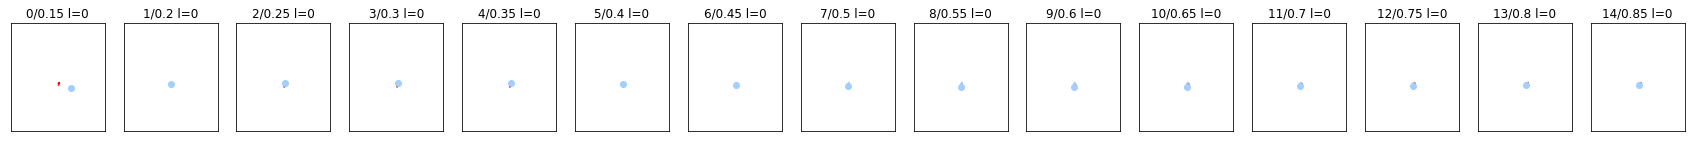

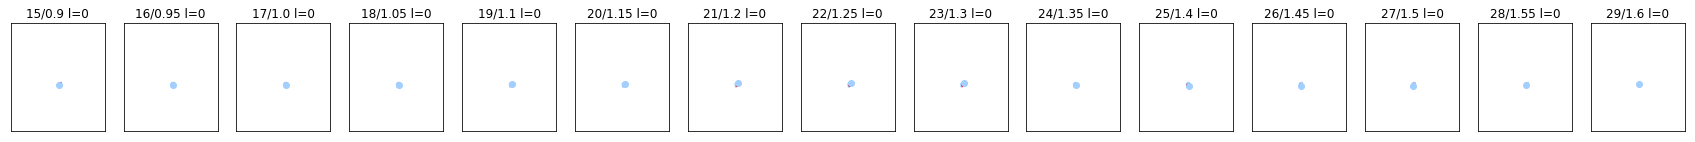

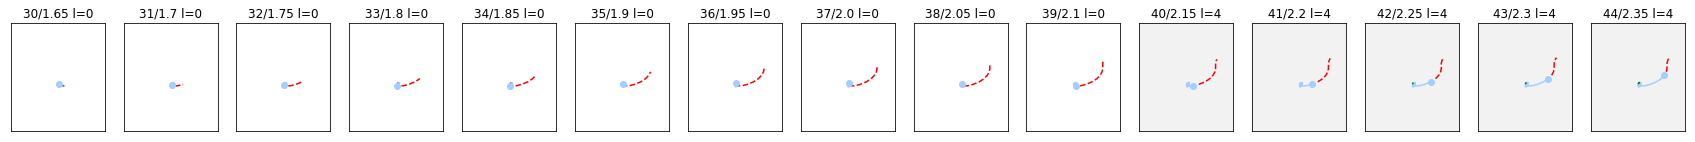

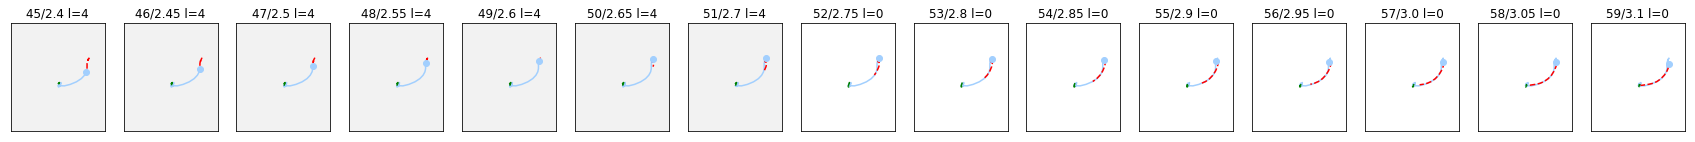

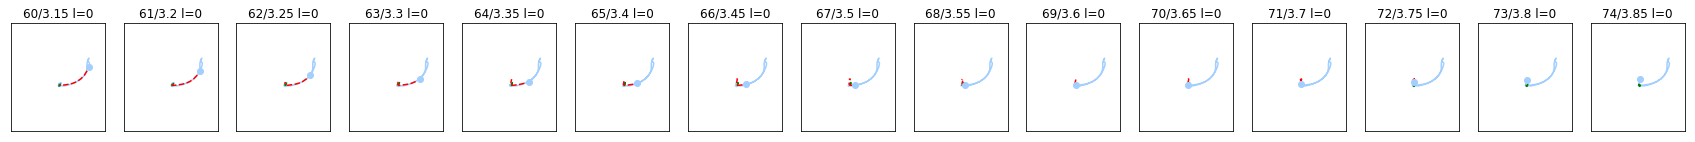

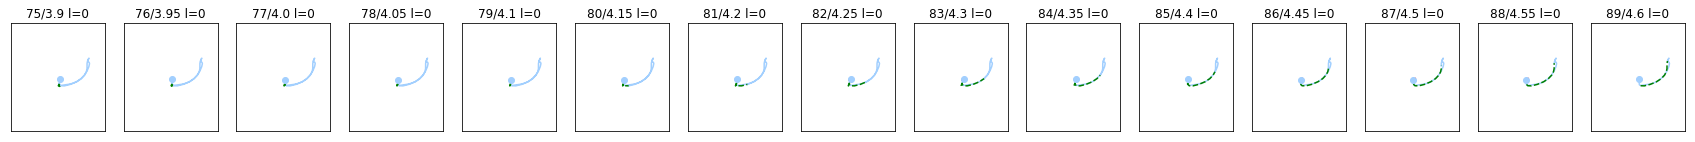

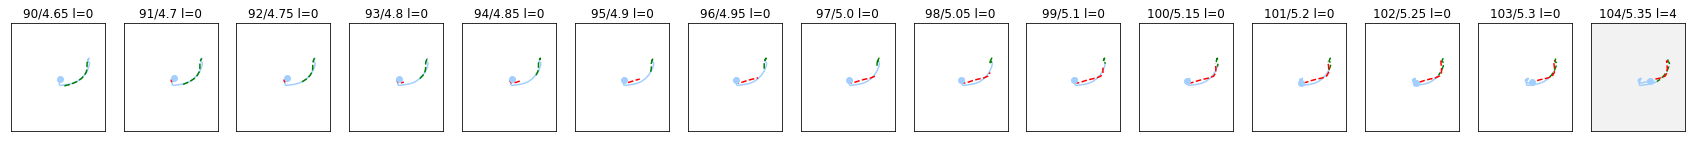

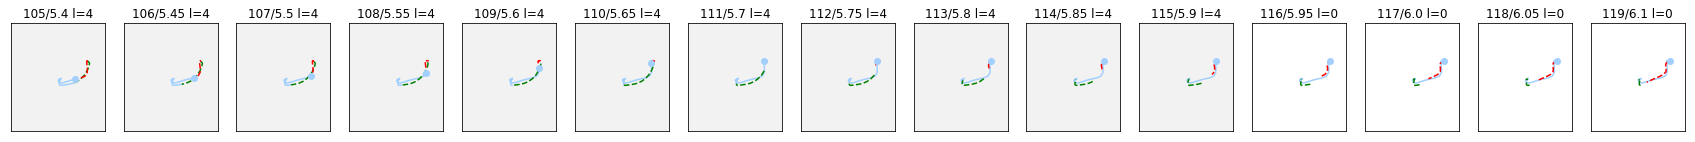

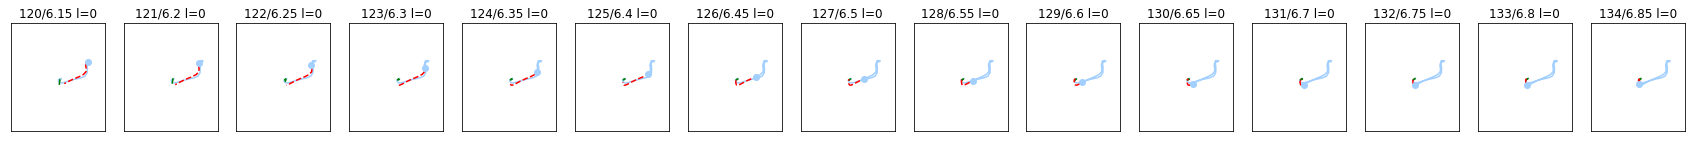

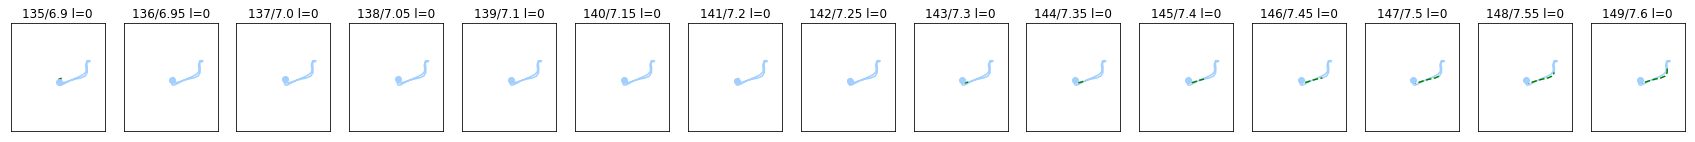

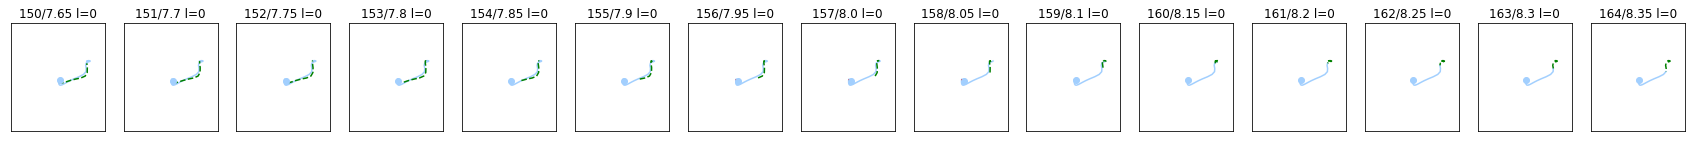

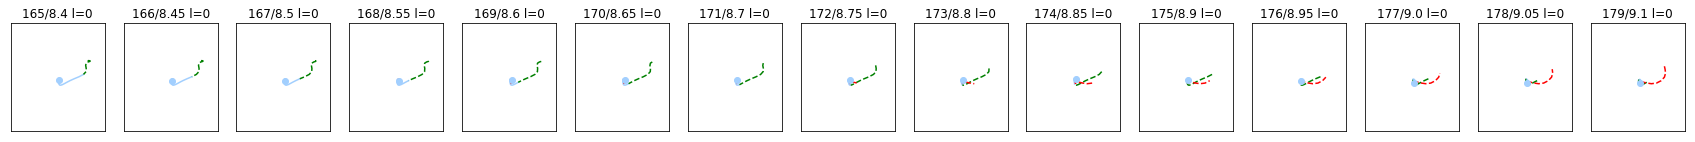

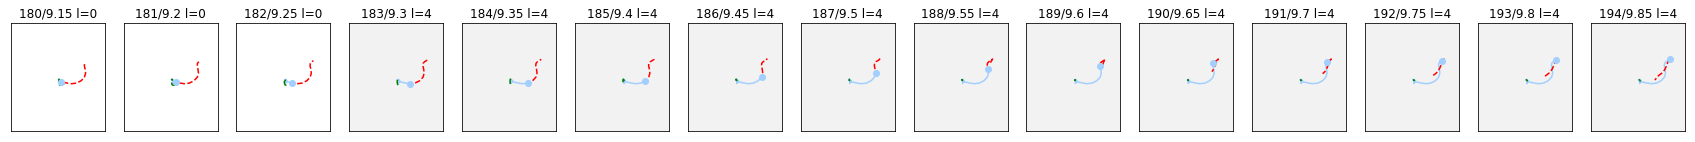

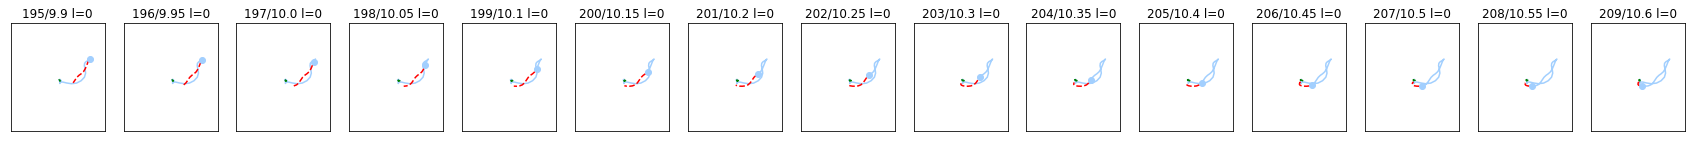

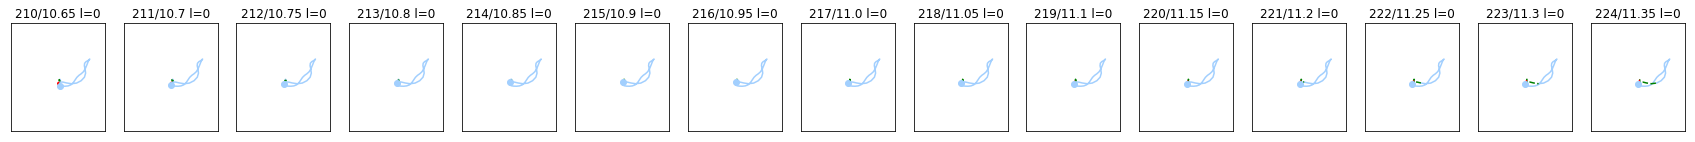

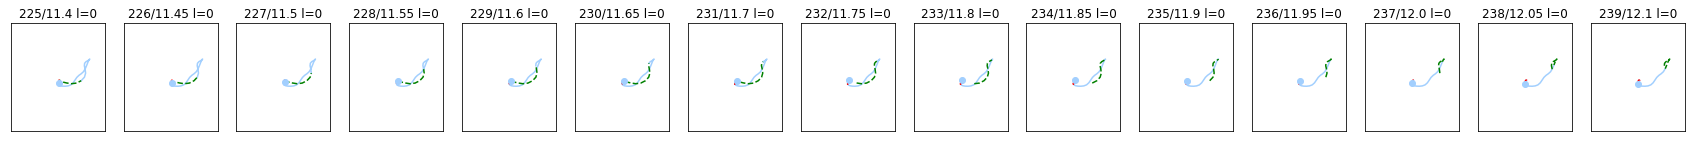

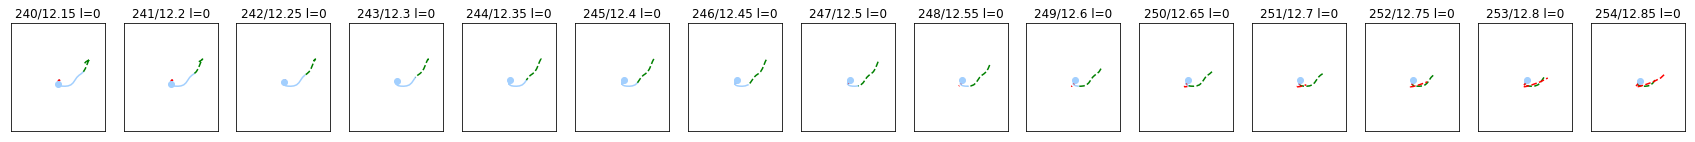

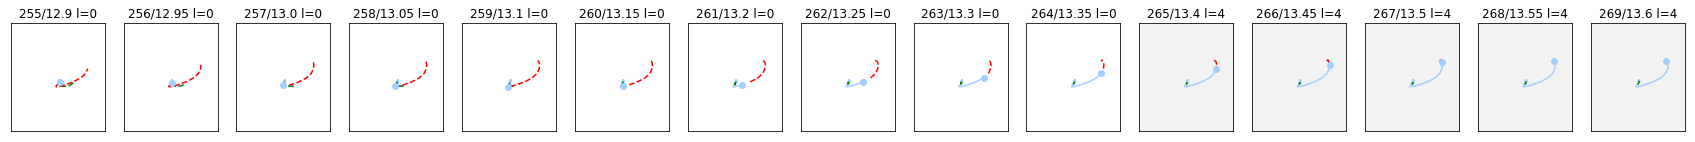

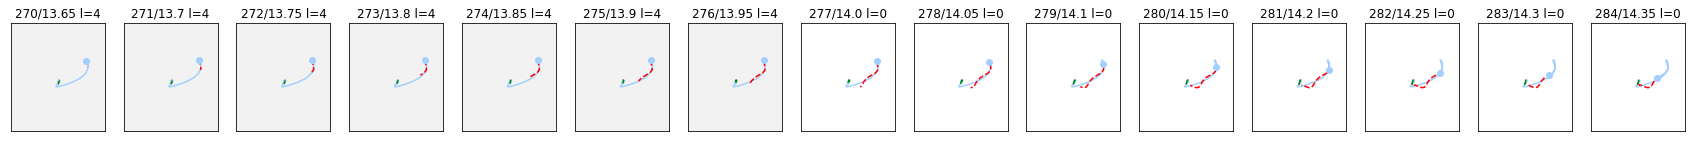

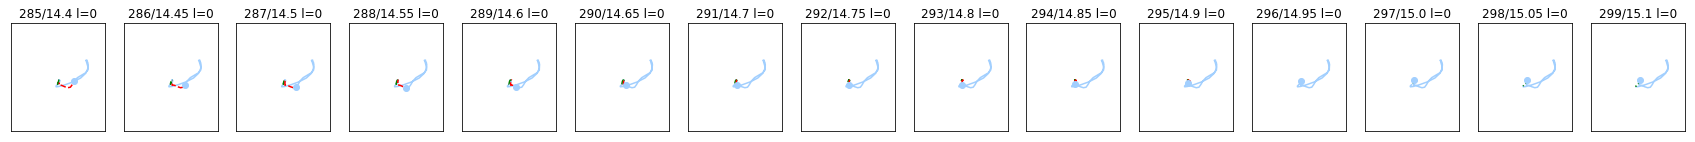

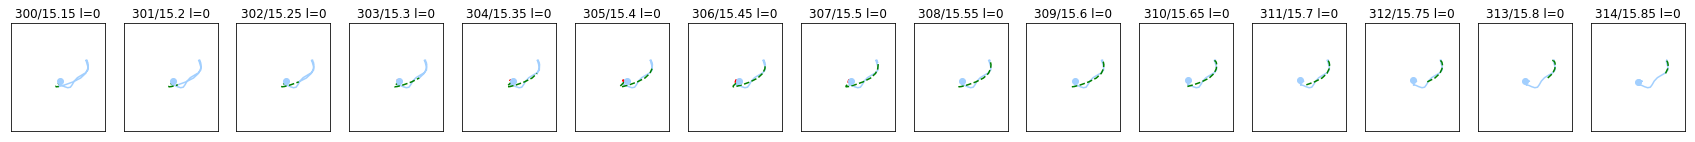

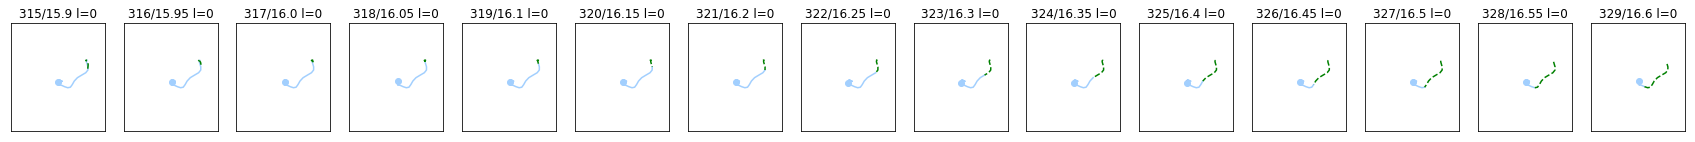

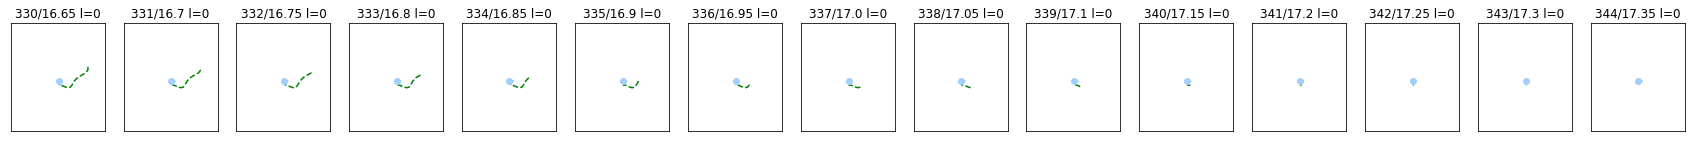

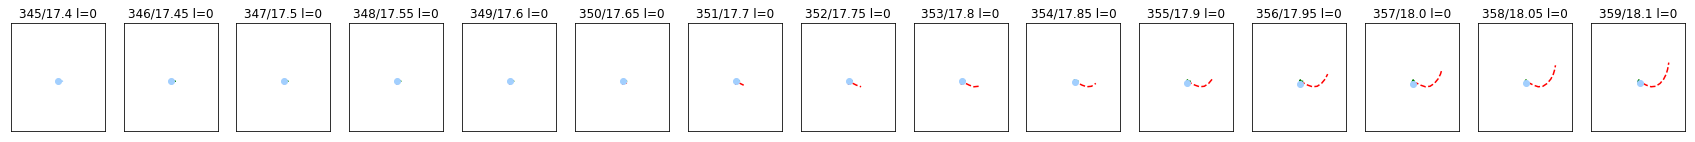

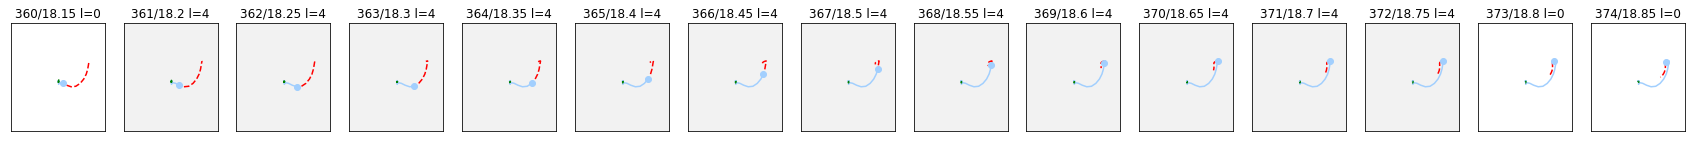

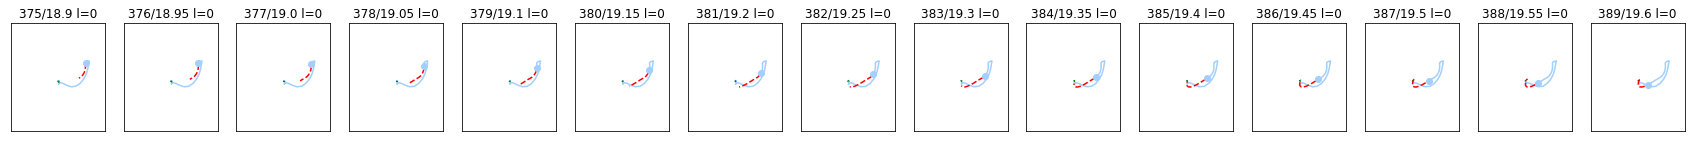

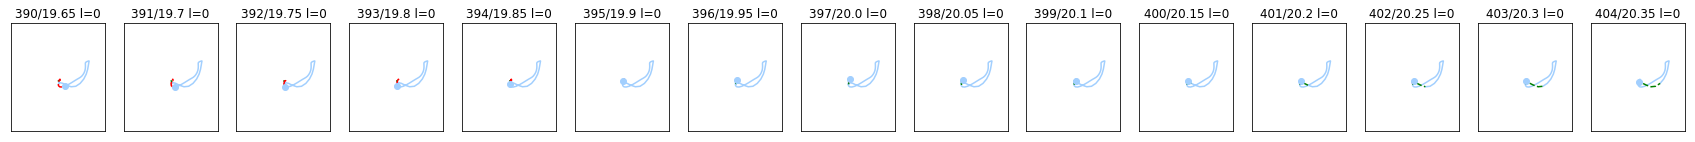

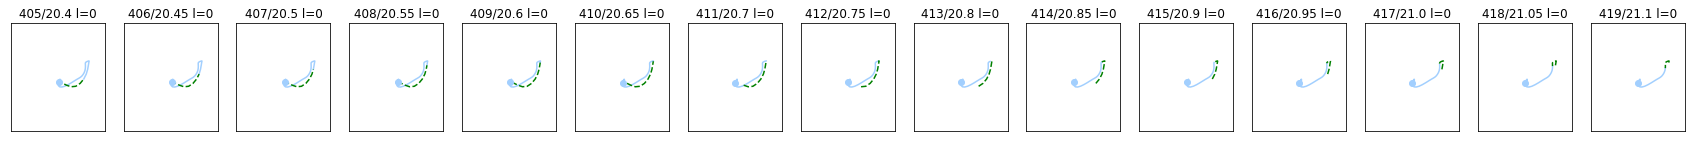

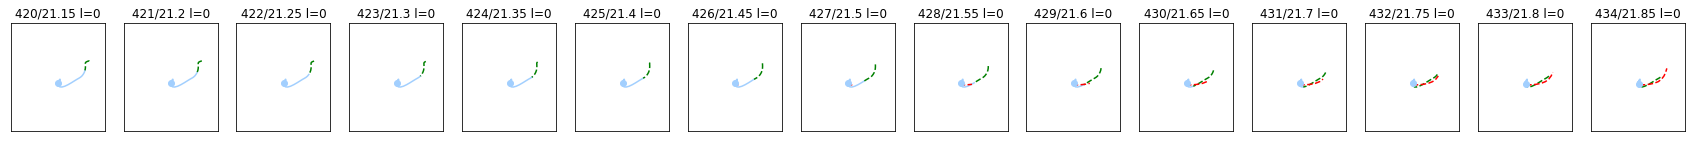

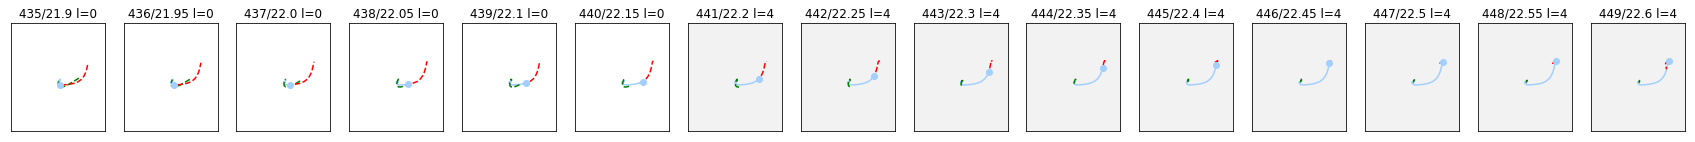

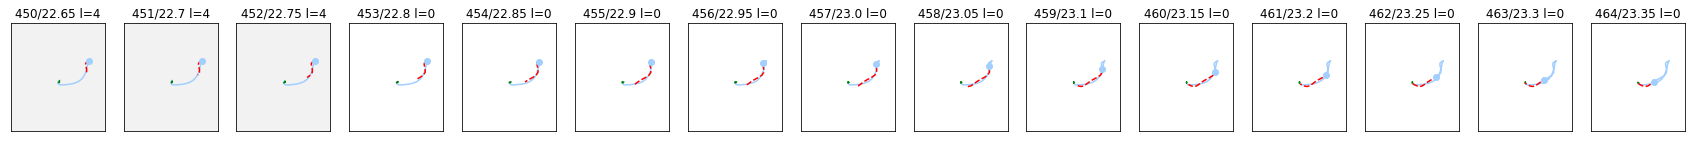

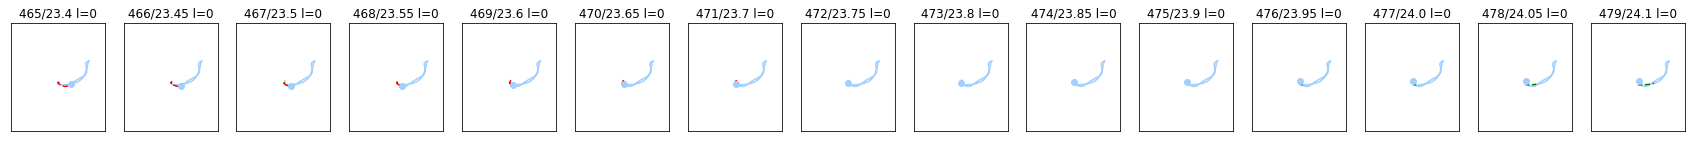

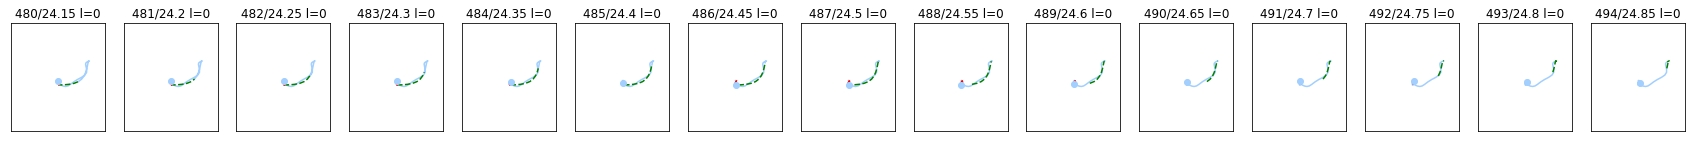

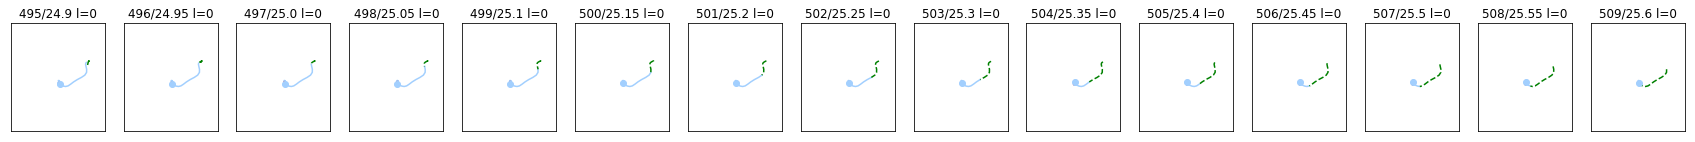

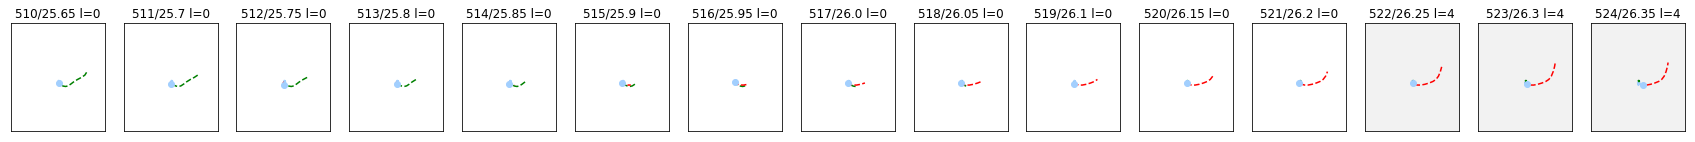

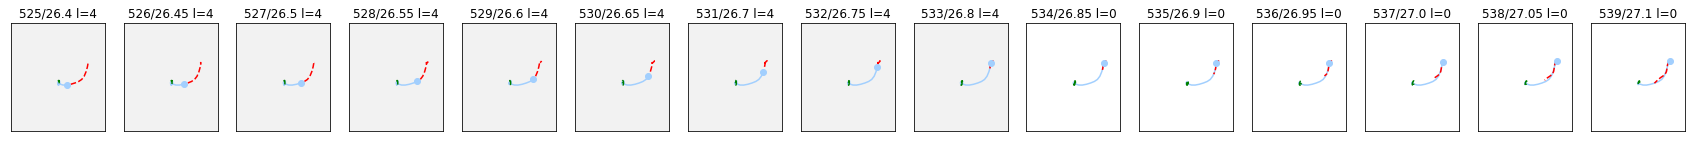

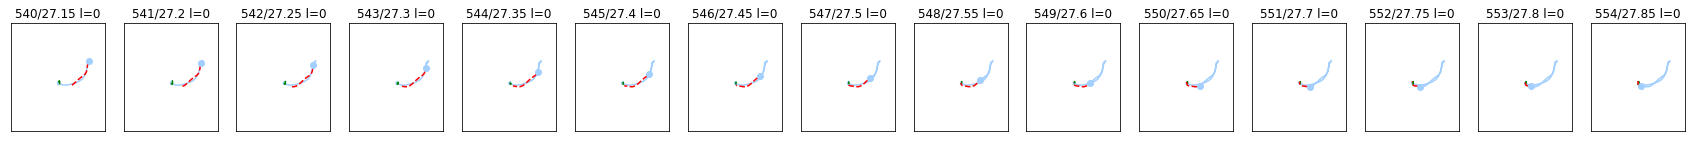

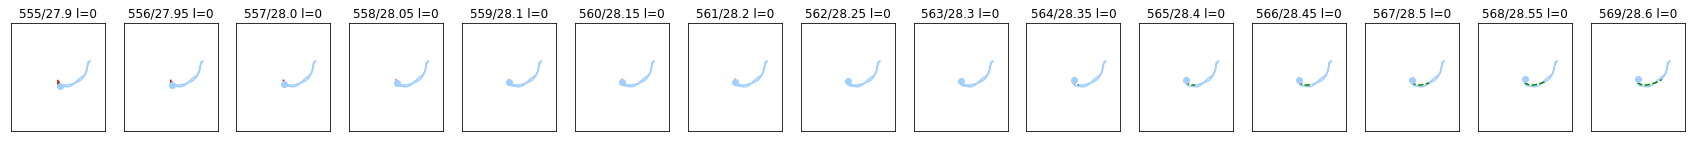

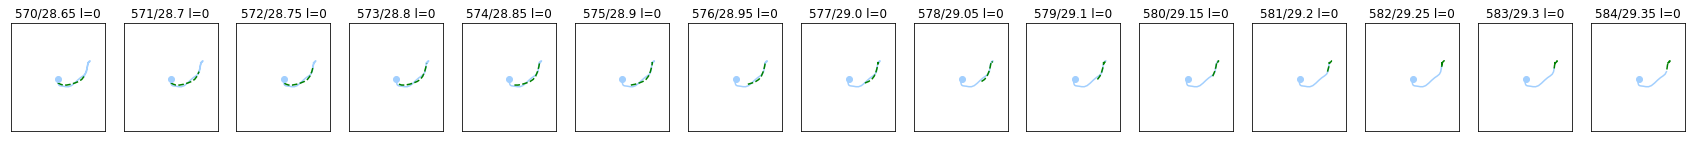

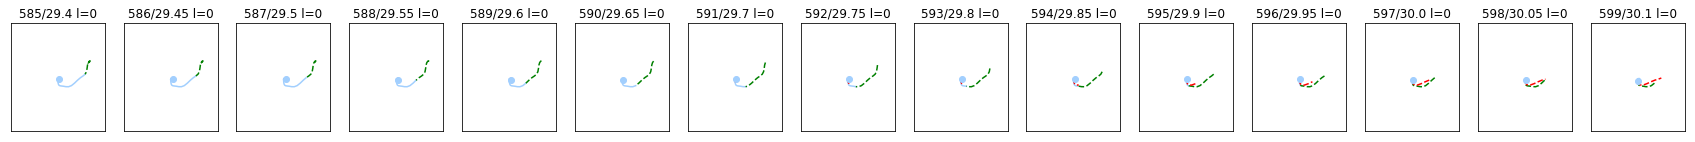

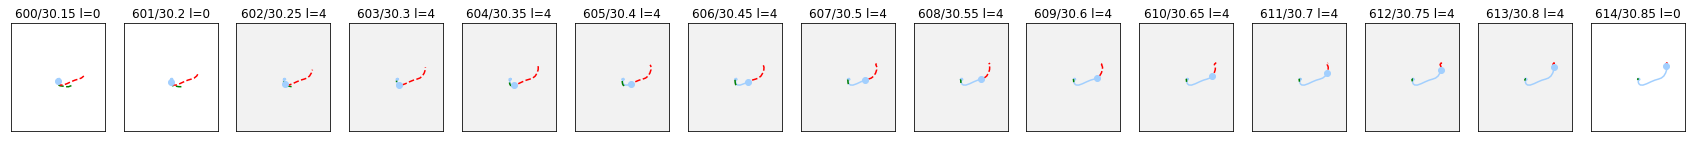

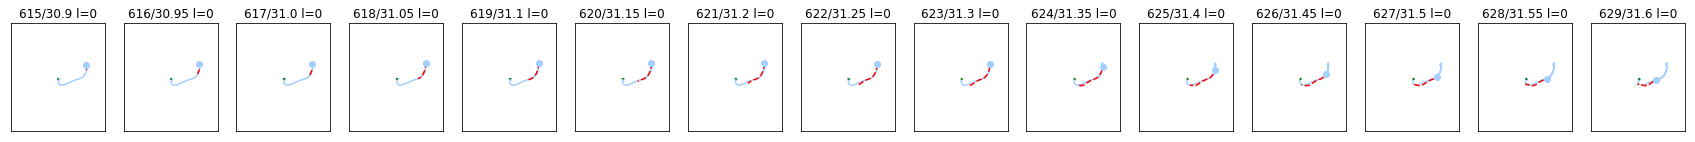

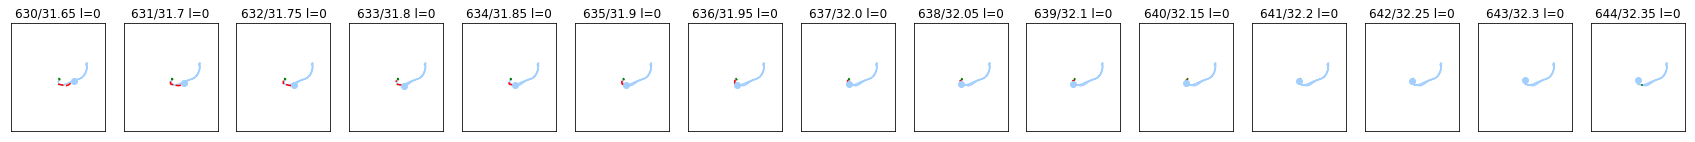

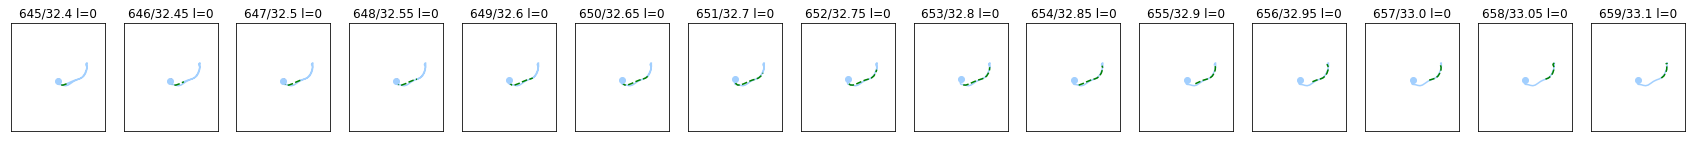

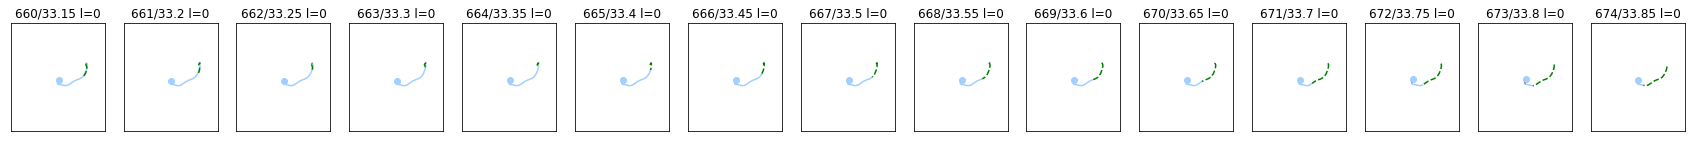

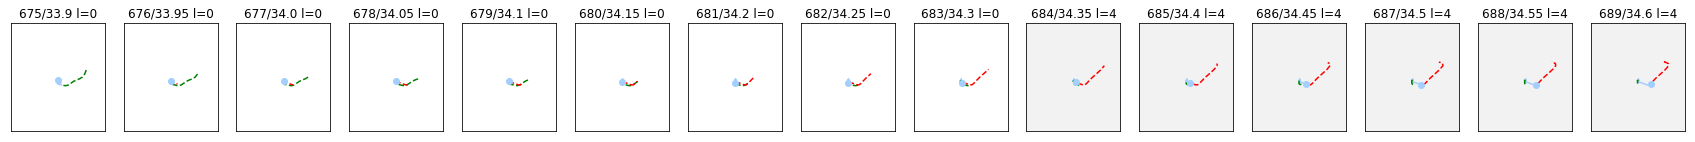

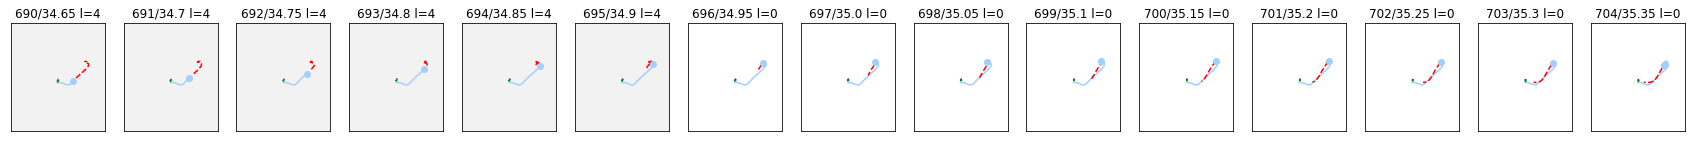

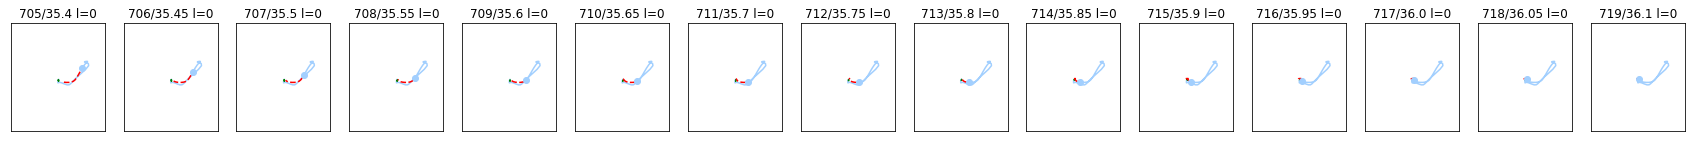

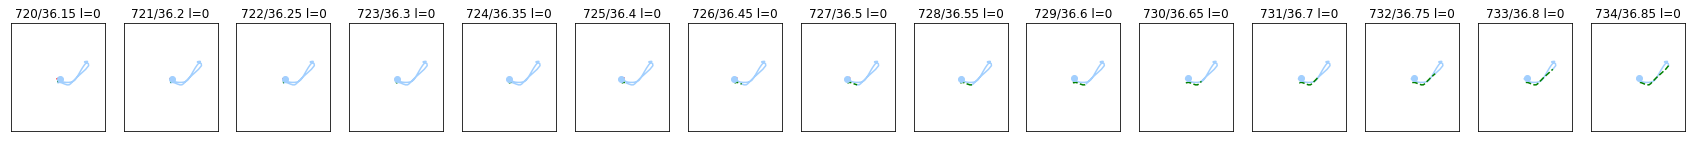

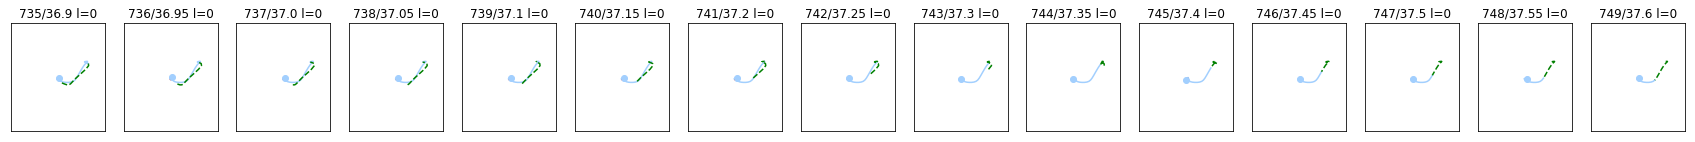

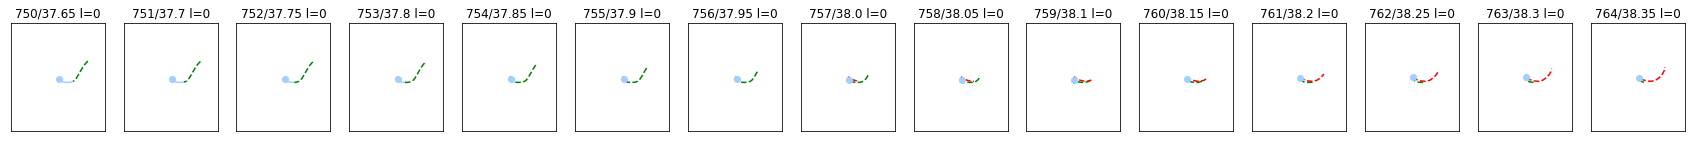

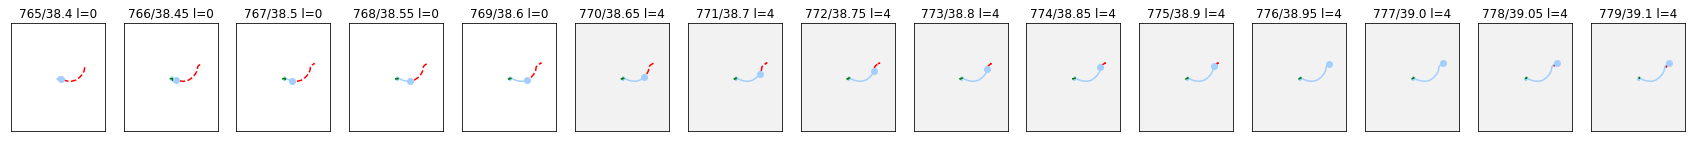

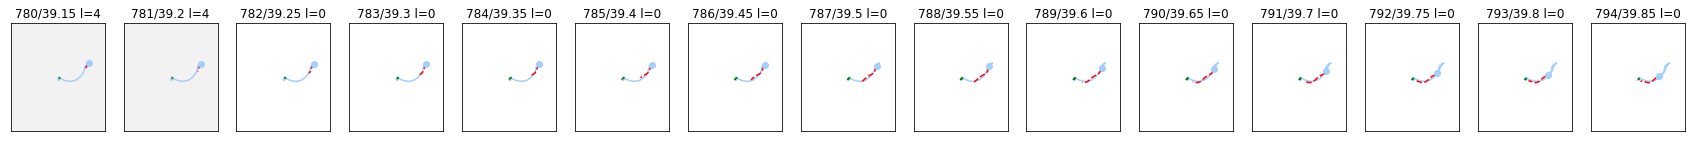

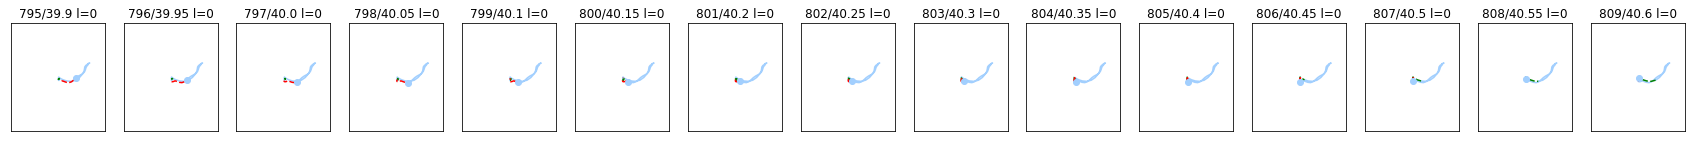

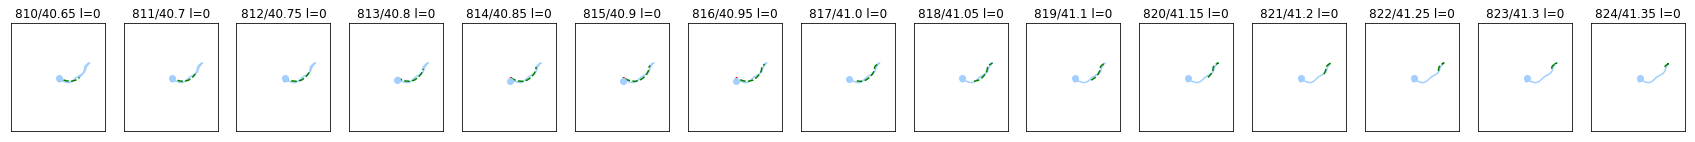

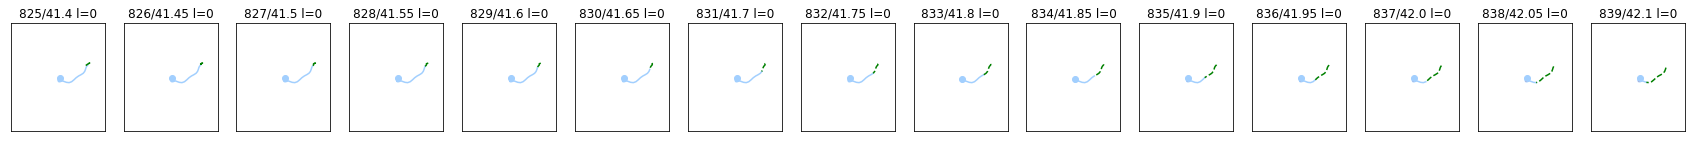

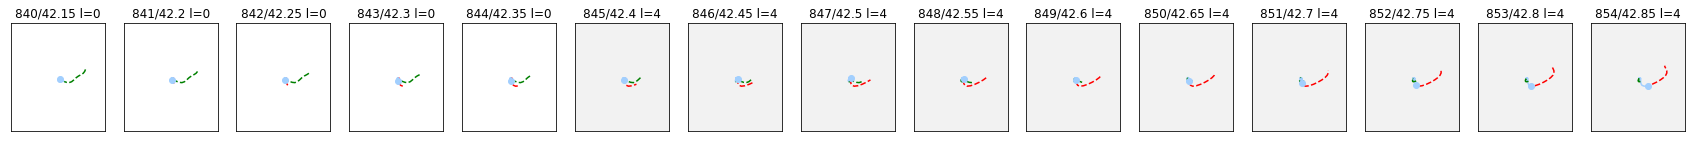

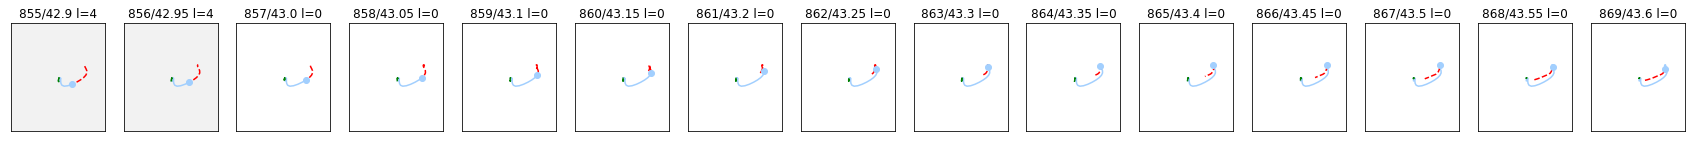

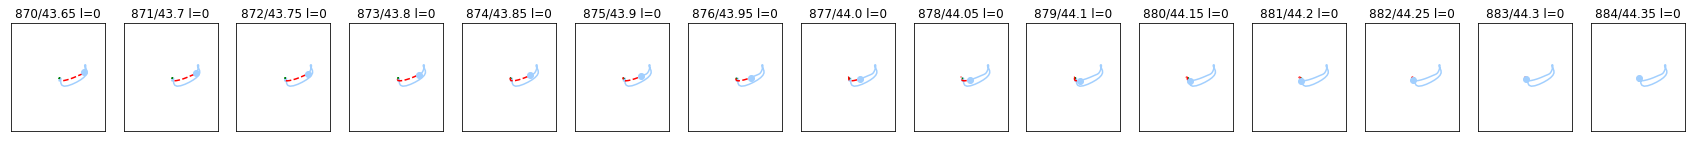

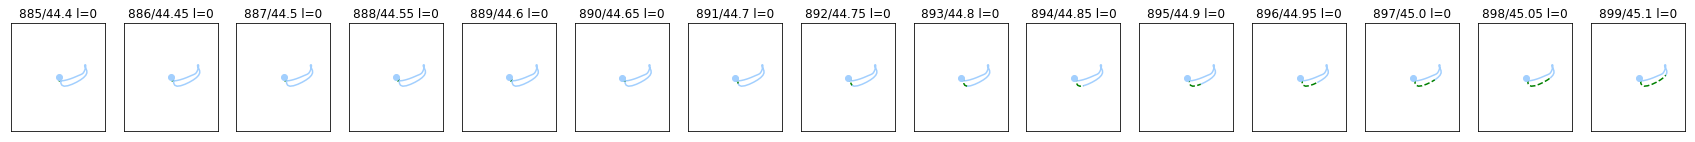

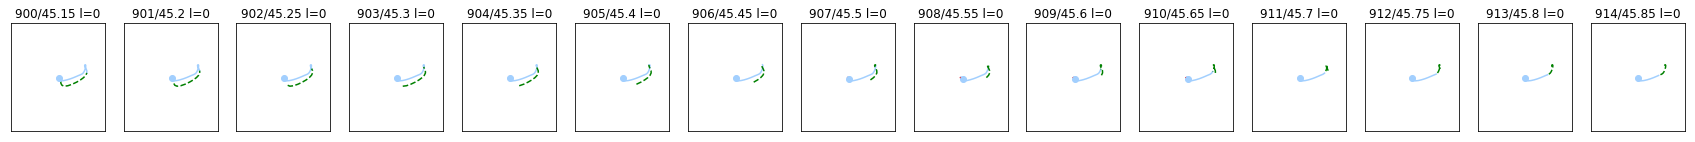

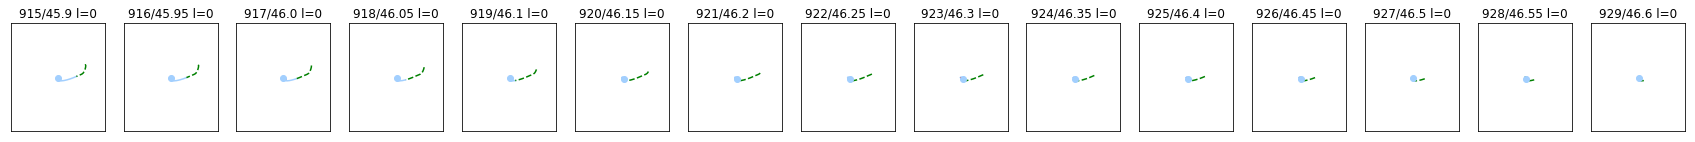

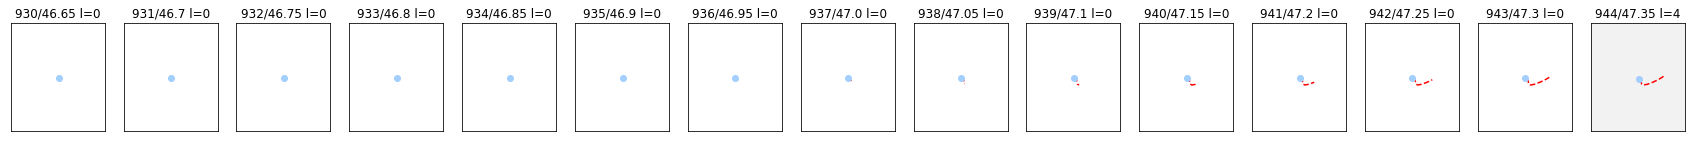

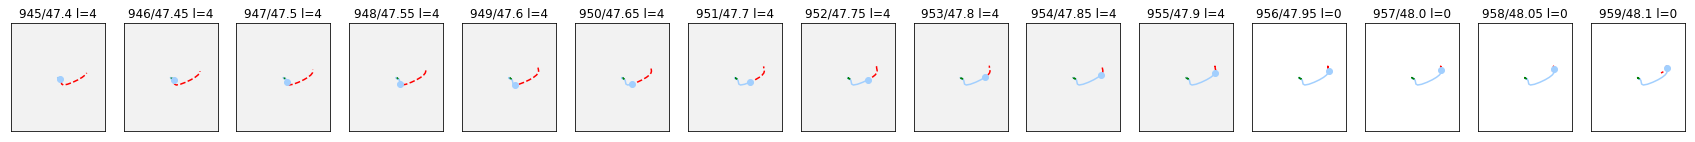

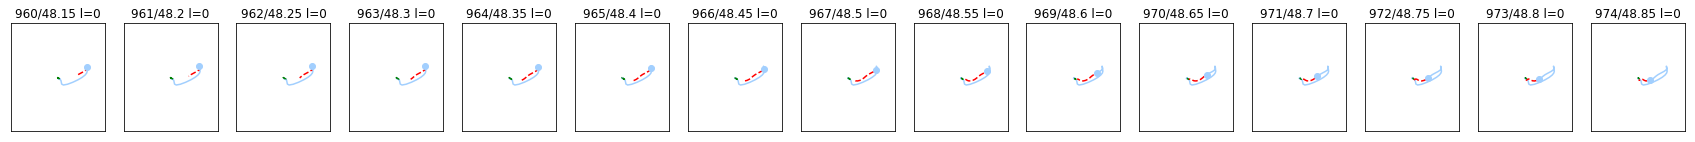

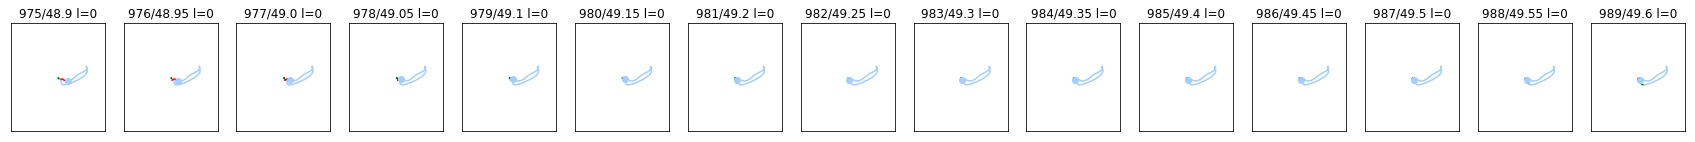

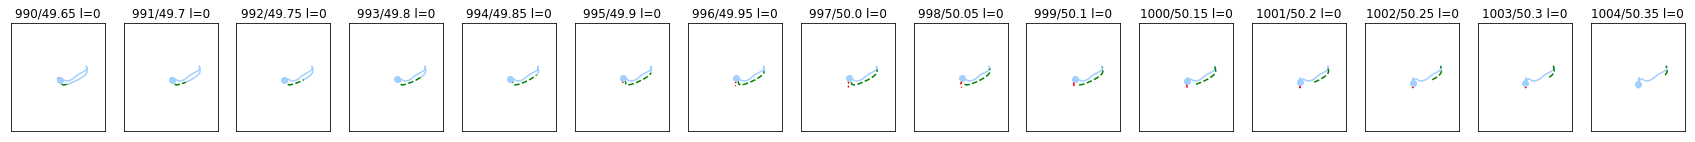

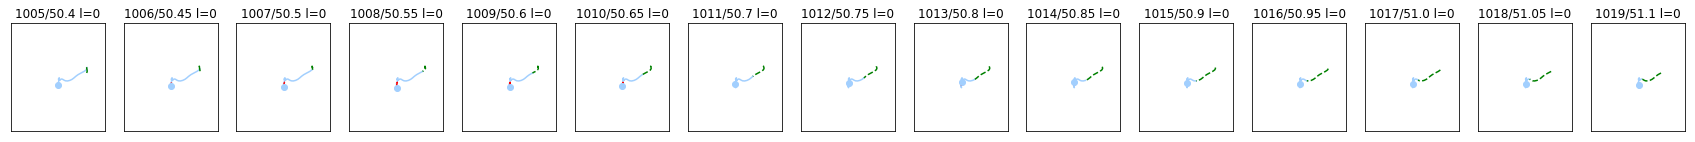

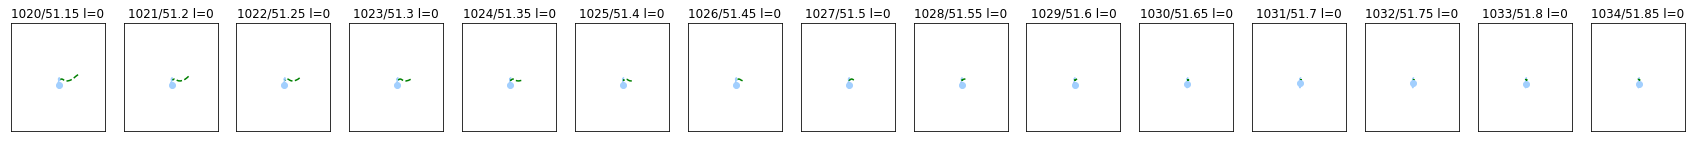

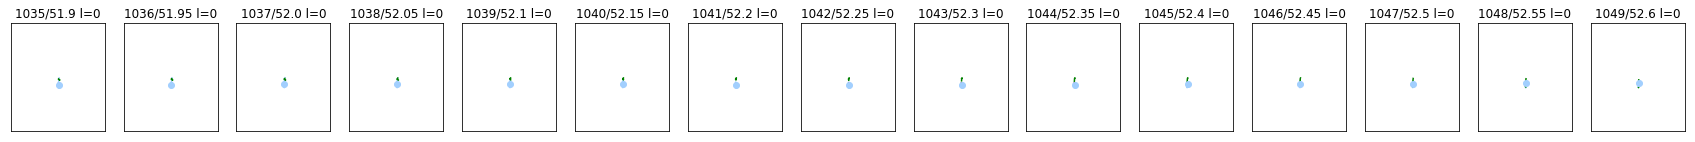

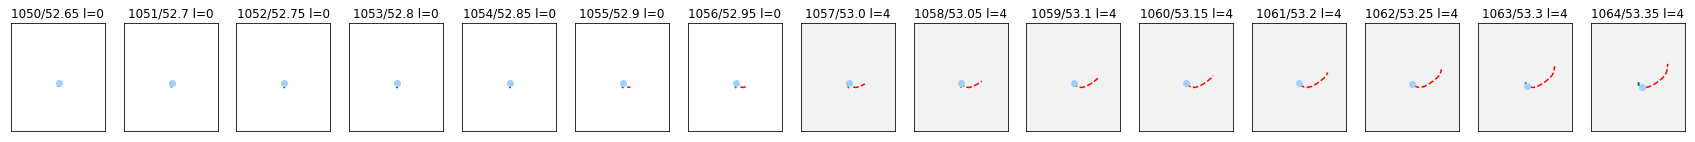

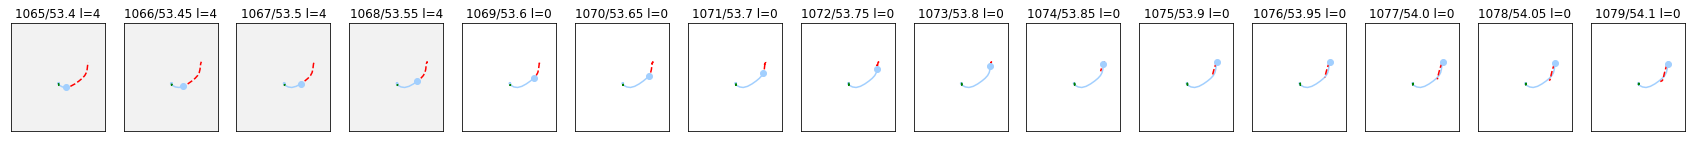

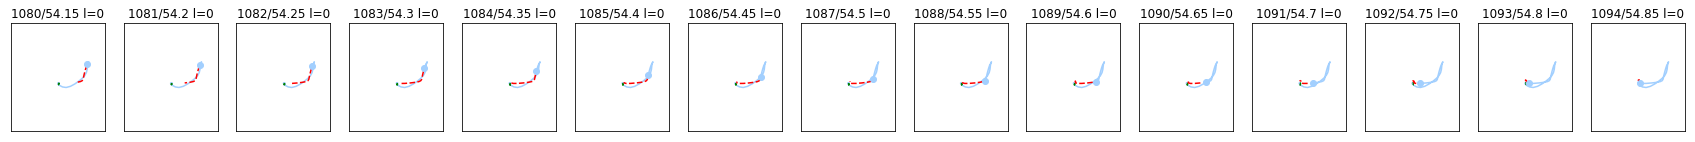

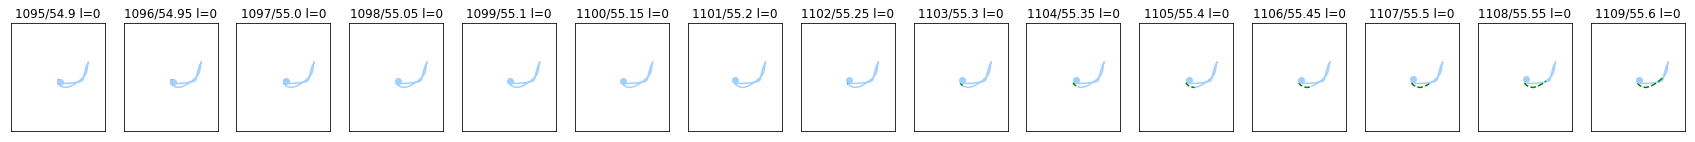

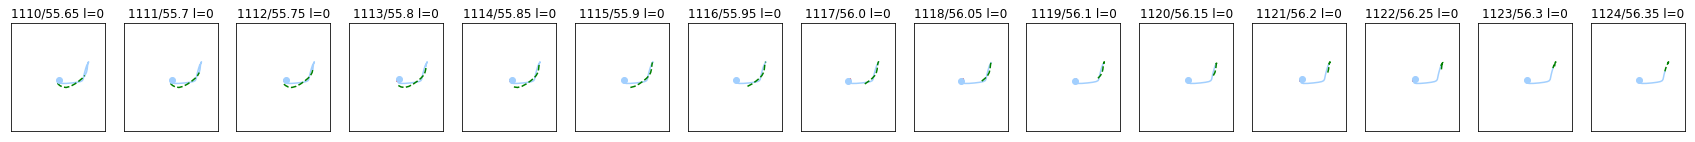

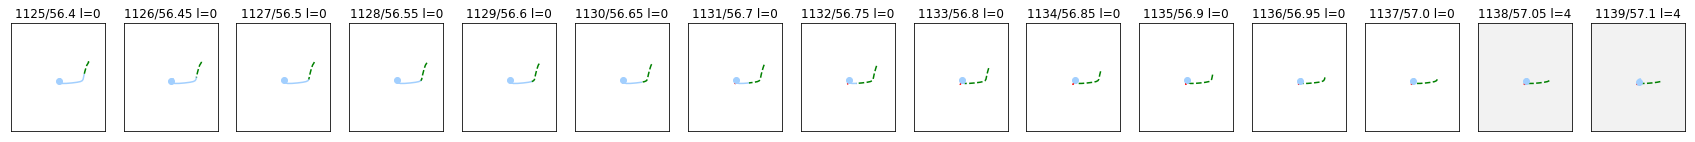

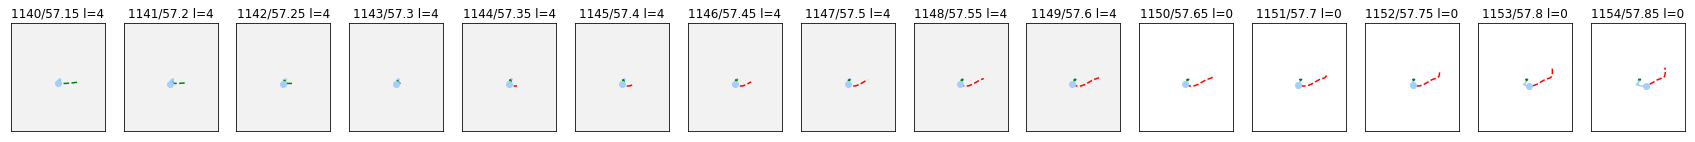

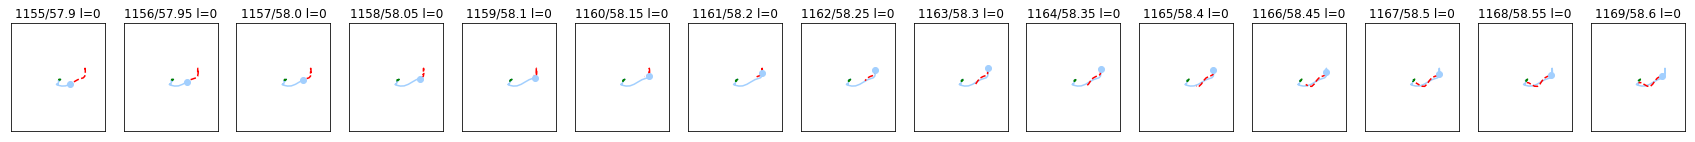

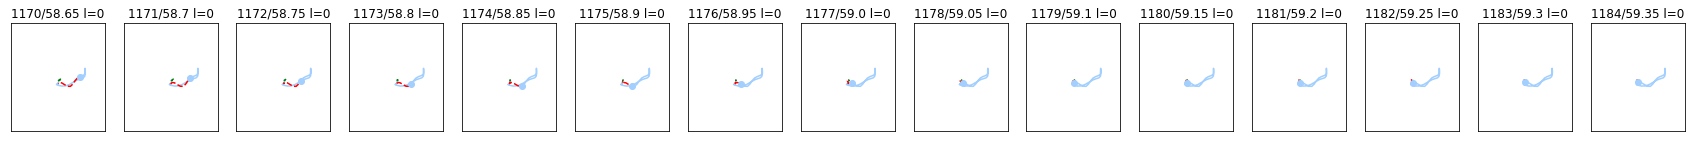

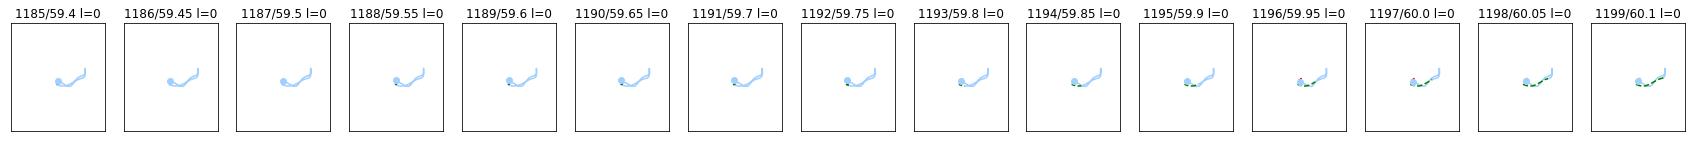

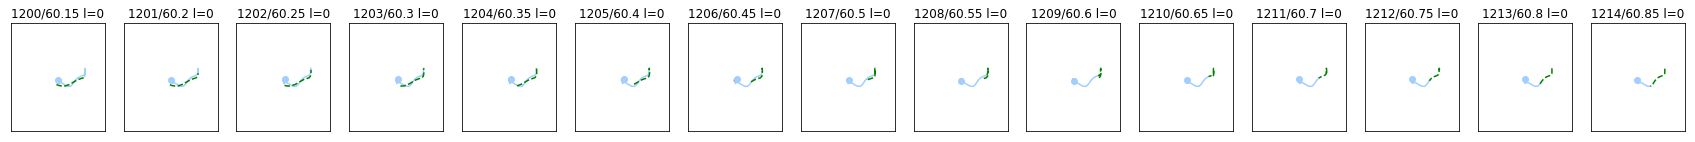

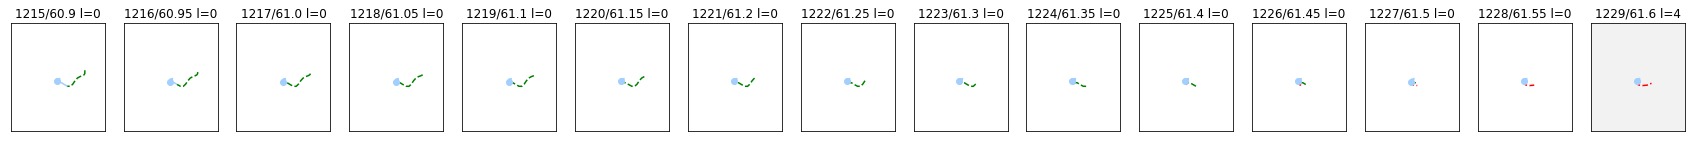

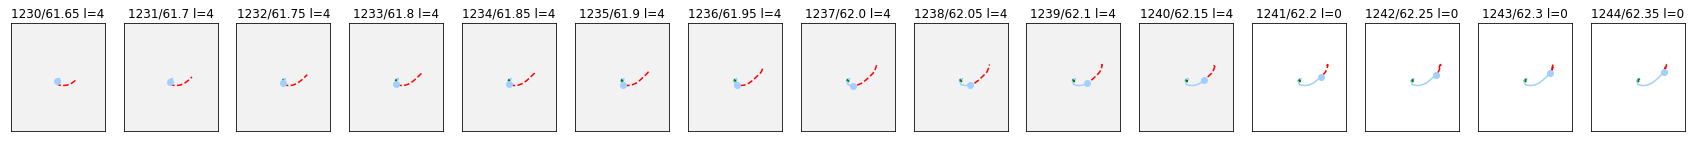

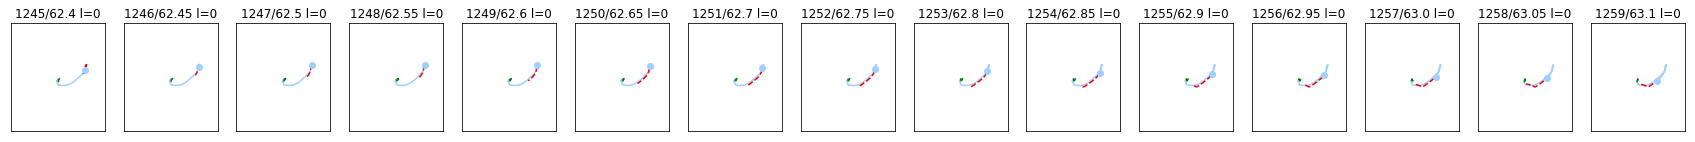

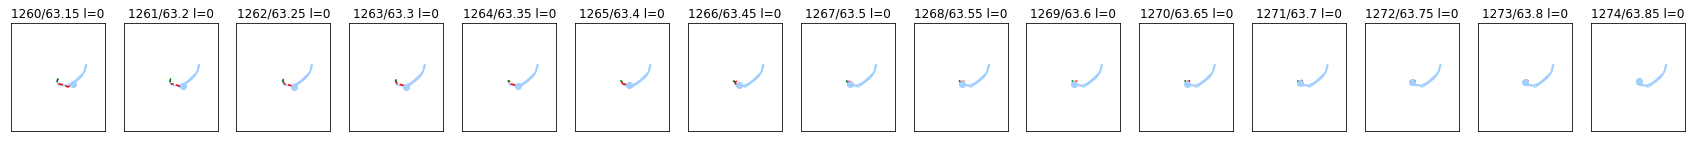

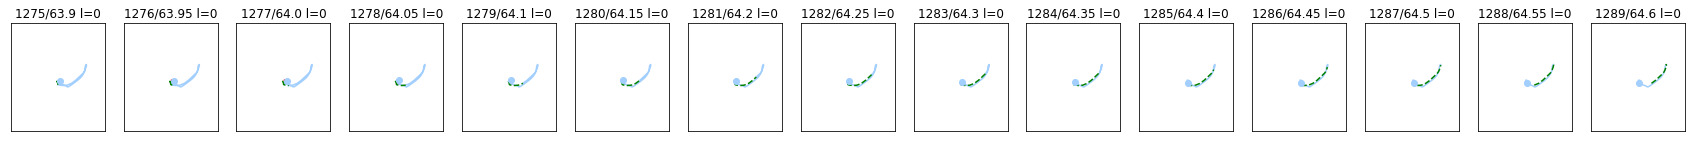

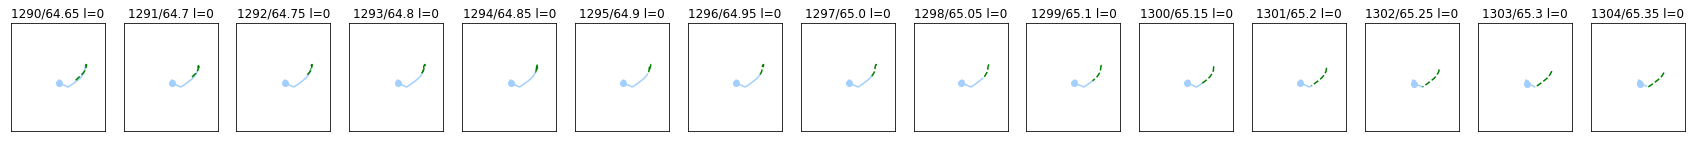

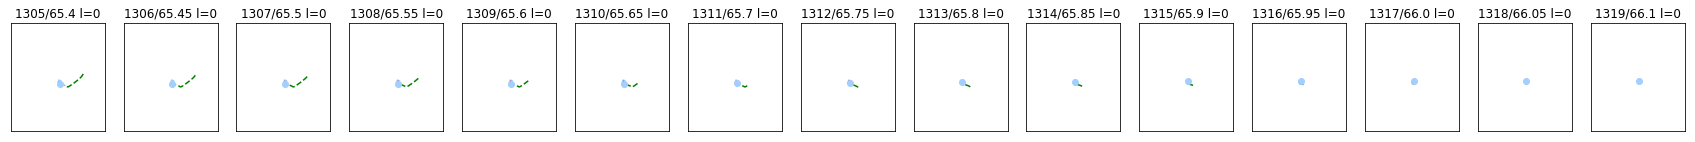

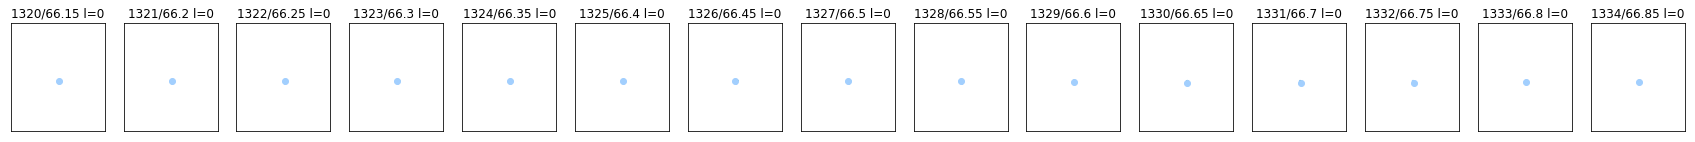

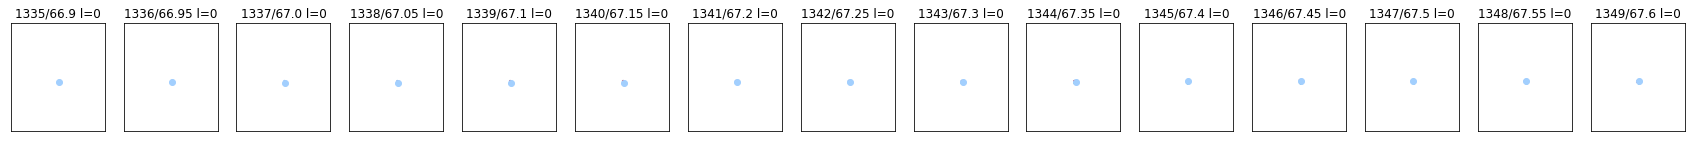

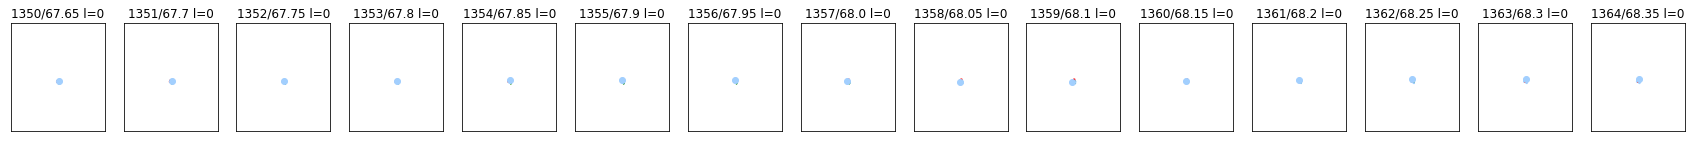

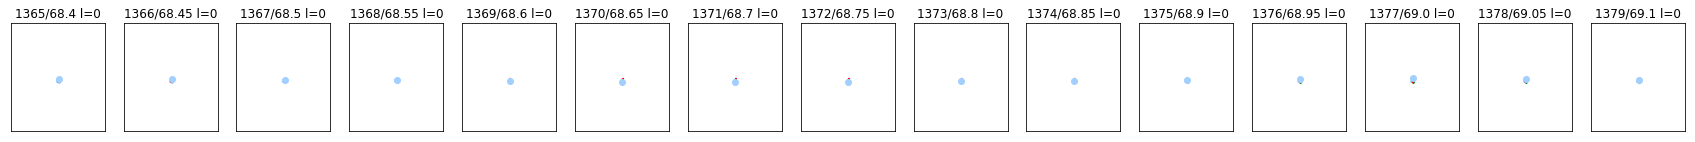

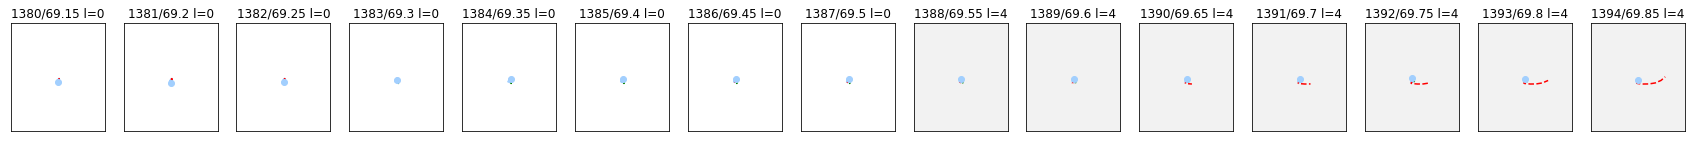

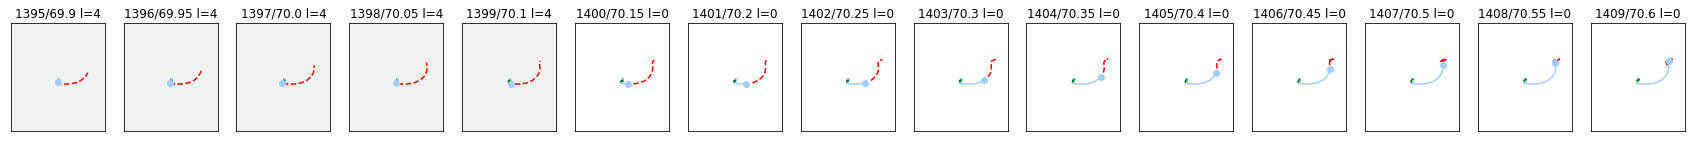

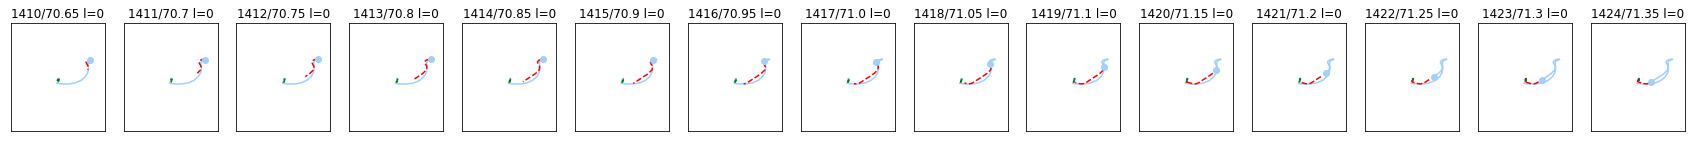

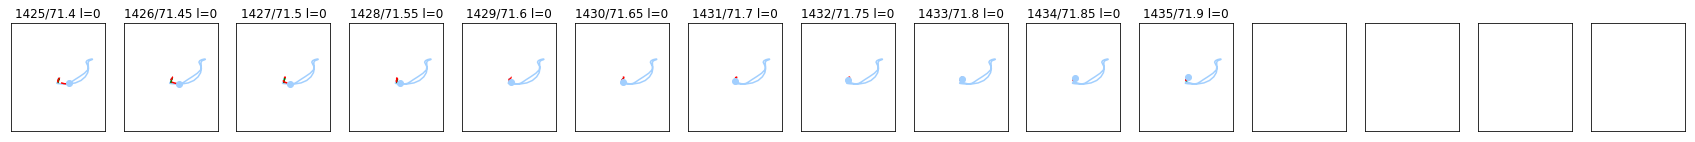

In [21]:
file_id = 19
plot_charts(de, file_id=file_id, tail=10, head=10, plots_per_row=15, body_part='rightWrist', is_frame_based = is_frame_based)

Display the movement endpoints (in milliseconds) of all non-zero labeled gestures:

In [ ]:
de.LabelGenerators[file_id].label_df.join(de.LabelGenerators[file_id].label_info)

Display the indices of movement ends of all non-zero labeled gestures:

In [ ]:
lgen = de.LabelGenerators[file_id]
y = lgen.y

gt = GestureTransformer(byrow=True, feature_names=feature_names)
X = gt.transform(lgen.X)

gt = GestureTransformer(feature_names)
P = gt.transform(de.X)

key = 'leftWrist'
kx = key + '_x'
ky = key + '_y'

# get the label which is used in the current file
lab = y[y>0][0]

this_set = True
if not this_set: #use all the data
    movementData = P[np.isclose(de.y,lab),:,:]
else:
    movementData = X[np.isclose(y,lab),:,:]

print(movementData.shape)
movementData = movementData[:,:,[feat_dict[kx],feat_dict[ky]]]
avgMovement = movementData.mean(axis = 0)
avgMovement